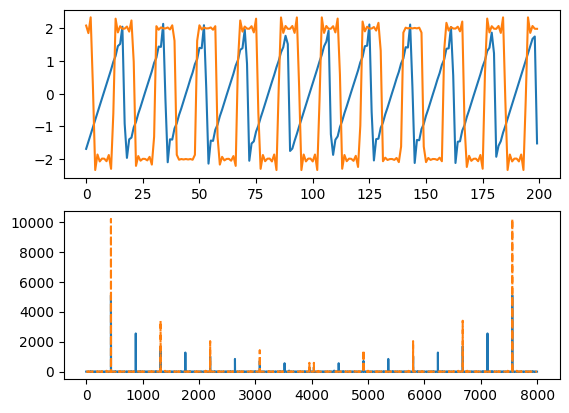

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal

def get_square(A, f, phi, sr, N, fac=10):
    # Compute antialiased square wave
    t = np.arange(N*fac)/(sr*fac)
    y = A*np.sign(np.cos(2*np.pi*f*t + phi))
    if fac > 1:
        # Antialias
        b, a = signal.butter(8, 1/fac)
        y = signal.filtfilt(b, a, y)
        y = y[0::fac]
    return y

def get_sawtooth(A, f, phi, sr, N, fac=10):
    T = sr*fac/f
    y = (np.arange(N*fac) + phi*T/(2*np.pi)) % T
    y = y/np.max(y)
    y = A*2*(y-0.5)
    if fac > 1:
        # Antialias
        b, a = signal.butter(8, 1/fac)
        y = signal.filtfilt(b, a, y)
        y = y[0::fac]
    return y

sr = 8000
y1 = get_sawtooth(2, 440, 0.5, sr, sr, fac=10)
y2 = get_square(2, 440, 0.5, sr, sr, fac=10)
plt.subplot(211)
plt.plot(y1[0:200])
plt.plot(y2[0:200])
plt.subplot(212)
plt.plot(np.abs(np.fft.fft(y1)))
plt.plot(np.abs(np.fft.fft(y2)), linestyle='--')
ipd.Audio(y1, rate=sr)

In [15]:
class SquareSawtooth(Dataset):
    def __init__(self, n_examples, pmin, pmax, sr, N, snr=10, do_fft=False):
        """
        Parameters
        ----------
        n_examples: int
            Number of examples per epoch
        pmin: int
            Minimum note number
        pmax: int
            Maximum note number
        sr: int
            Sample rate
        N: int
            Number of samples per example
        snr: float
            Signal to noise ratio
        """
        # Create randomized fixed notes
        self.pmin = pmin
        self.pmax = pmax
        self.snr = snr
        self.sr = sr
        self.N = N
        self.n_examples = n_examples
    
    def __len__(self):
        return self.n_examples
    
    def __getitem__(self, idx):
        ## TODO: 
        x = []
        y = 0
        ## If the sample index is even, generate a random square wave with label 0
        amp = np.random.randn()
        phase = np.random.rand()*2*np.pi
        p = np.random.randint(self.pmin, self.pmax+1)
        freq = 440*2**(p/12)
        if (idx % 2 == 0):
            # def get_square(A, f, phi, sr, N, fac=10):
            x = get_square(A=amp, f=freq, phi=phase, sr=self.sr, N=self.N)
        ## If the sample index is odd, generate a random sawtooth wave with label 1
        else:
            x = get_sawtooth(A=amp, f=freq, phi=phase, sr=self.sr, N=self.N)
            y = 1
            
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return x, y

Device cpu


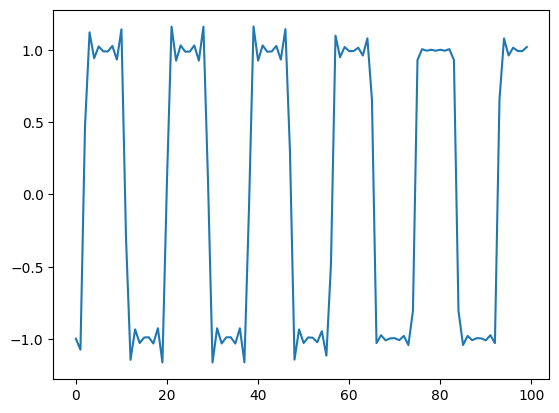

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device", device)

sr = 8000 # Sample rate
N = 1000 # Number of audio samples per clip

p1 = 0
p2 = 0
data = SquareSawtooth(2000, p1, p2, sr, N, do_fft=True)
x, y = data[2]
plt.plot(x[0:100])

In [18]:
## TODO: Setup a perceptron of the right dimension
perceptron = nn.Linear(N, 1)

perceptron = perceptron.to(device)
optimizer = torch.optim.Adam(perceptron.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()


n_epochs = 50
losses = []
accuracy = []
for epoch in range(n_epochs):
    loader = DataLoader(data, batch_size=16, shuffle=True)
    total_loss = 0
    total_correct = 0
    for i, (X, Y) in enumerate(loader):
        X = X.to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        Y_est = perceptron(X) # Run model on inputs
        loss = loss_fn(Y_est[:, 0], Y) # Compute loss function
        loss.backward() # Compute gradient of loss function wrt model parameters
        optimizer.step() # Update the parameters according to the gradient
        
        loss = loss.item()
        ## TODO: Accumulate loss and the number of correct
        total_loss += loss
        Y_est = 0.5*(torch.sign(Y_est)+1)
        total_correct = torch.sum(torch.abs(Y*Y_est))
    
    losses.append(loss)
    accuracy.append(total_correct/len(data))
    print(losses)


## Plot the results of training
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(losses)
plt.title("Losses")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.subplot(212)
plt.plot(accuracy)
plt.title("Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

In [ ]:
# 0 is square
# 1 is sawtooth
x0 = np.abs(np.fft.fft(get_square(1, 440, 0, sr, N)))
x0 /= np.max(x0)
x1 = np.abs(np.fft.fft(get_sawtooth(1, 440, 0, sr, N)))
x1 /= np.max(x1)
p = next(perceptron.parameters()).cpu().detach().flatten()
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(x0, c='C0')
plt.title("Square Wave Example")
pl.subplot(312)
plt.plot(x1, c='C1')
plt.title("Sawtooth Wave Example")
plt.subplot(313)
plt.plot(p*3, c='C2')
plt.title("Logistic Coefficients")